# Point Cloud Aggregation & Moving Object Filtering
**Author:** Pravin Oli  
**Neptune Code:** XUUSY9  

**Course:** 3D Sensing and Sensor fusion  
**Project:** Point Cloud Aggregation Based on GNSS-INS Data and Moving Object Filtering  
**Dataset:** nuScenes v1.0-mini  
**Sensors:** LiDAR, GNSS-INS, Cameras  

This notebook implements:  
1. GNSS-INS based point cloud aggregation  
2. Moving object filtering without annotations  
3. Point cloud colorization using camera images  

# Notebook Contents:  
1. Imports & Environment Setup  
2. Configuration & Dataset Loading  
3. Utility Functions 
 
4. Task 1: Point Cloud Aggregation  
     4.1 Raw LiDAR in sensor frame  
     4.2 Transform LiDAR to world frame  
     4.3 Aggregate all frames  

5. Task 2: Moving Object Filtering  
     5.1 Temporal consistency filtering  
     5.2 Spatial clustering filtering  
     5.3 Visualize each step  

 6. Task 3: Point Cloud Colorization  





# 1. Imports & Environment Setup

In [1]:
# 1. Imports & Environment Setup

import os
import numpy as np
import cv2
import yaml
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
import open3d as o3d
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.geometry_utils import view_points
from scipy.ndimage import map_coordinates

# For inline visualization
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 2. Configuration & Dataset Loading

In [2]:
# 2. Configuration & Dataset Loading

CONFIG = {
    "dataset_root": "../datasets/v1.0-mini",   # path to nuScenes mini dataset
    "version": "v1.0-mini",
    "lidar_sensor": "LIDAR_TOP",
    "camera_sensors": [
        "CAM_FRONT", "CAM_FRONT_LEFT", "CAM_FRONT_RIGHT",
        "CAM_BACK", "CAM_BACK_LEFT", "CAM_BACK_RIGHT"
    ],
    "voxel_size": 0.2,           # voxel size for filtering
    "min_observations": 3        # temporal threshold for filtering
}

print("Dataset files:", os.listdir(CONFIG["dataset_root"]))

# Load nuScenes dataset
nusc = NuScenes(
    version=CONFIG["version"],
    dataroot=CONFIG["dataset_root"],
    verbose=True
)
print("NuScenes dataset loaded successfully!")


Dataset files: ['LICENSE', 'v1.0-mini', 'maps', 'sweeps', '.v1.0-mini.txt', 'samples']
Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.700 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
NuScenes dataset loaded successfully!


# 3. Utility Functions

In [3]:
# 3. Helper / Utility Functions


def pose_to_matrix(translation, rotation):
    """
    Convert translation and quaternion rotation to a 4x4 transformation matrix.
    """
    T = np.eye(4)
    T[:3, :3] = Quaternion(rotation).rotation_matrix
    T[:3, 3] = translation
    return T

def load_lidar_points(nusc, sample_data_token):
    """
    Load LiDAR points (x, y, z) from a given sample_data token.
    """
    sd = nusc.get("sample_data", sample_data_token)
    
    # Handle both possible key names
    if "filename" in sd:
        file_path = os.path.join(nusc.dataroot, sd["filename"])
    elif "file_name" in sd:
        file_path = os.path.join(nusc.dataroot, sd["file_name"])
    else:
        raise KeyError("No file path found in sample_data")
    
    # Load binary LiDAR data
    points = np.fromfile(file_path, dtype=np.float32).reshape(-1, 5)
    return points[:, :3]

def visualize_open3d(points, colors=None, window_name="Point Cloud"):
    """
    Visualize point cloud using Open3D.
    """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    if colors is not None:
        pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd], window_name=window_name)

def visualize_matplotlib(points, color_axis=2, title="Point Cloud"):
    """
    Simple inline 2D visualization (color by Z by default) using matplotlib.
    """
    z = points[:, color_axis]
    plt.figure(figsize=(8,6))
    plt.scatter(points[:,0], points[:,1], c=z, cmap='jet', s=1)
    plt.colorbar(label="Z / Height")
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.show()

# 4. Task-1: Point Cloud Aggregation  
**Goal:**  
 1. Visualize raw LiDAR points in sensor frame  
 2. Transform LiDAR points to world frame  
 3. Aggregate multiple frames into a global point cloud  

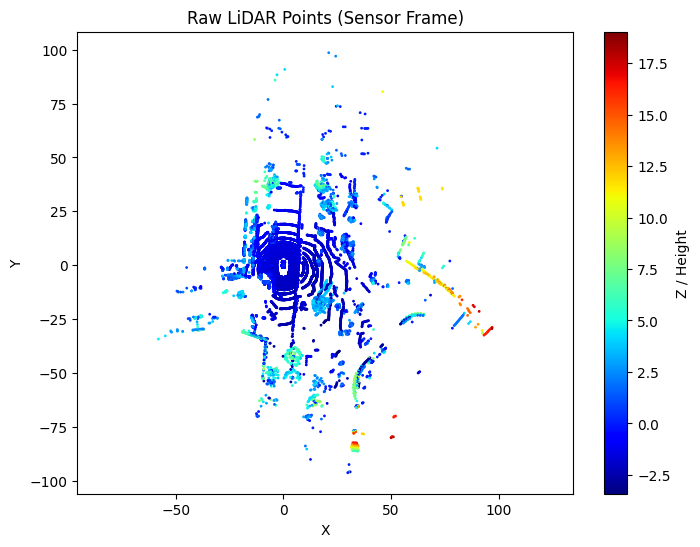

In [4]:
# 4.1 Raw LiDAR Visualization (Sensor Frame)

# Pick first scene and first sample
scene = nusc.scene[0]
sample_token = scene["first_sample_token"]
sample = nusc.get("sample", sample_token)
lidar_token = sample["data"][CONFIG["lidar_sensor"]]

# Load raw LiDAR points (sensor frame)
raw_points = load_lidar_points(nusc, lidar_token)

# Inline 2D visualization (XY)
visualize_matplotlib(raw_points, color_axis=2, title="Raw LiDAR Points (Sensor Frame)")

# Open3D 3D visualization
visualize_open3d(raw_points, colors=None, window_name="Raw LiDAR Points (Sensor Frame)")

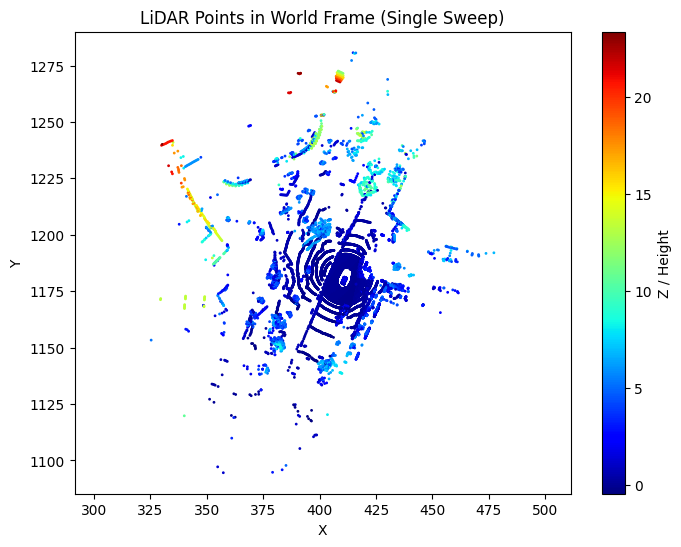

In [5]:
# 4.2 Transform LiDAR Points to World Frame

def transform_lidar_to_world(nusc, sd_token):
    """
    Transform LiDAR points from sensor frame to world frame using calibrated sensor
    and ego poses.
    """
    sd = nusc.get("sample_data", sd_token)
    cs = nusc.get("calibrated_sensor", sd["calibrated_sensor_token"])
    ego = nusc.get("ego_pose", sd["ego_pose_token"])

    T_lidar_ego = pose_to_matrix(cs["translation"], cs["rotation"])
    T_ego_world = pose_to_matrix(ego["translation"], ego["rotation"])

    points = load_lidar_points(nusc, sd_token)
    points_h = np.hstack((points, np.ones((points.shape[0], 1))))

    points_world = (T_ego_world @ T_lidar_ego @ points_h.T).T
    return points_world[:, :3]

# Transform first frame
world_points_single = transform_lidar_to_world(nusc, lidar_token)

# Inline plot
visualize_matplotlib(world_points_single, color_axis=2, title="LiDAR Points in World Frame (Single Sweep)")

# Open3D 3D visualization
visualize_open3d(world_points_single, colors=None, window_name="LiDAR Points in World Frame (Single Sweep)")

Aggregated 39 sweeps into 1354112 points


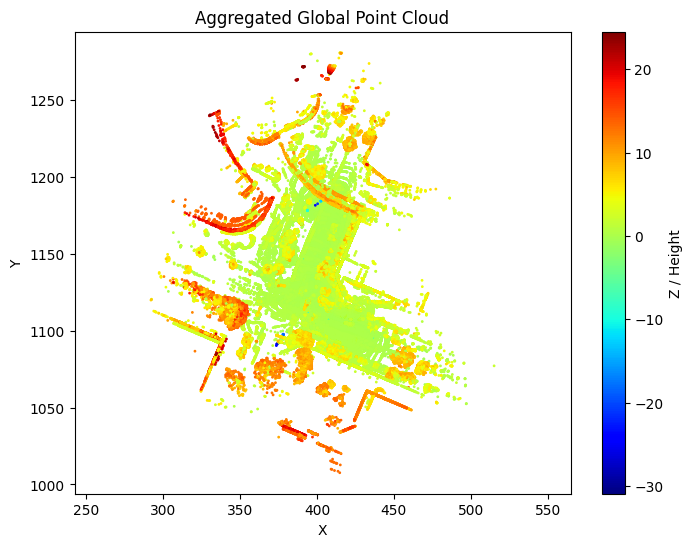

In [6]:

# 4.3 Aggregate All Frames in Scene

def aggregate_scene_points(nusc, scene):
    """
    Aggregate all LiDAR frames in a scene into a single global point cloud
    in world coordinates.
    """
    sample_token = scene["first_sample_token"]
    sweep_points = []

    while sample_token:
        sample = nusc.get("sample", sample_token)
        lidar_token = sample["data"][CONFIG["lidar_sensor"]]
        pts_world = transform_lidar_to_world(nusc, lidar_token)
        sweep_points.append(pts_world)
        sample_token = sample["next"]

    global_points = np.vstack(sweep_points)
    return sweep_points, global_points

# Aggregate points
sweep_world_points, global_points = aggregate_scene_points(nusc, scene)

print(f"Aggregated {len(sweep_world_points)} sweeps into {global_points.shape[0]} points")

# Inline visualization (XY)
visualize_matplotlib(global_points, color_axis=2, title="Aggregated Global Point Cloud")

# Open3D 3D visualization
visualize_open3d(global_points, colors=None, window_name="Aggregated Global Point Cloud")


# 5. Task-2: Moving Object Filtering

 **Goal:**
Remove moving objects from the aggregated point cloud to create a static map
Approach:
1. Temporal Consistency Filtering (keep voxels seen in multiple sweeps)
2. Spatial Filtering using DBSCAN (remove small clusters / noise)

In [7]:
# 5.1 Parameters

VOXEL_SIZE = 0.2              # meters
MIN_VOXEL_HIT_COUNT = 3       # min sweeps a voxel must appear in to be static
DBSCAN_EPS = 0.6              # meters
DBSCAN_MIN_POINTS = 15
MIN_CLUSTER_SIZE = 100

In [8]:
# 5.2 Helper Functions

def points_to_voxel_indices(points, origin, voxel_size):
    """
    Convert point coordinates to voxel indices
    """
    return np.floor((points - origin) / voxel_size).astype(np.int32)

def visualize_stage(points, title="Point Cloud Stage", color_axis=2):
    """
    Inline + Open3D visualization for a processing stage
    """
    # Inline XY scatter
    visualize_matplotlib(points, color_axis=color_axis, title=title)
    # Open3D 3D
    visualize_open3d(points, colors=None, window_name=title)

[Stage 1] Temporal consistency filtering: 613307 points


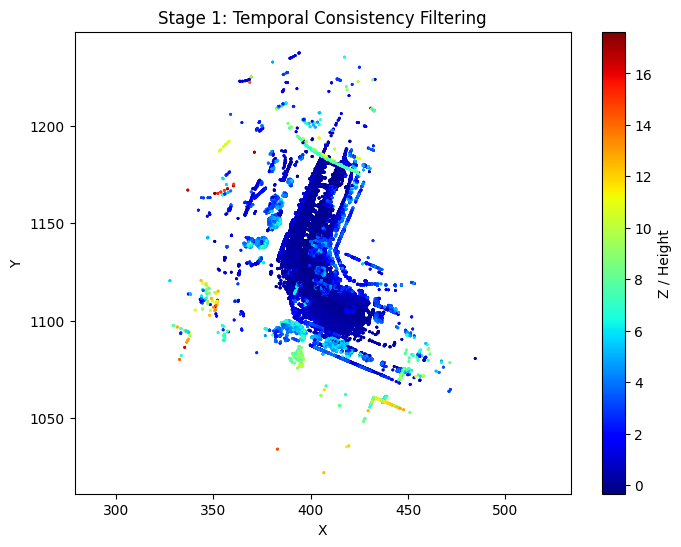

In [9]:
# 5.3 Stage 1: Temporal Consistency Filtering

valid_sweeps = [pts for pts in sweep_world_points if pts.shape[0] > 0] # Only keeps sweeps with points

# Compute global bounding box
global_min = np.min([pts.min(axis=0) for pts in valid_sweeps], axis=0)
voxel_origin = global_min

# Count how many times each voxel appears across sweeps
voxel_counter = Counter()
for pts in valid_sweeps:
    voxel_indices = points_to_voxel_indices(pts, voxel_origin, VOXEL_SIZE)
    unique_voxels = np.unique(voxel_indices, axis=0)
    for v in map(tuple, unique_voxels):
        voxel_counter[v] += 1

# Keep voxels seen in >= MIN_VOXEL_HIT_COUNT sweeps
kept_voxels = {v for v, count in voxel_counter.items() if count >= MIN_VOXEL_HIT_COUNT}

# Filter all points
all_points = np.vstack(valid_sweeps)
all_voxel_indices = points_to_voxel_indices(all_points, voxel_origin, VOXEL_SIZE)
kept_voxel_arr = np.array(list(kept_voxels), dtype=np.int32)

# Efficient mask using structured array view trick
dtype = np.dtype((np.void, kept_voxel_arr.dtype.itemsize * 3))
kept_view = kept_voxel_arr.view(dtype).ravel()
inds_view = np.ascontiguousarray(all_voxel_indices).view(dtype).ravel()
mask_stage1 = np.in1d(inds_view, kept_view)
static_points_stage1 = all_points[mask_stage1]

print(f"[Stage 1] Temporal consistency filtering: {static_points_stage1.shape[0]} points")

# Visualize Stage 1
visualize_stage(static_points_stage1, title="Stage 1: Temporal Consistency Filtering")


Precompute neighbors.[========================================] 100%
[Stage 2] DBSCAN spatial filtering: 598690 points=>] 97%


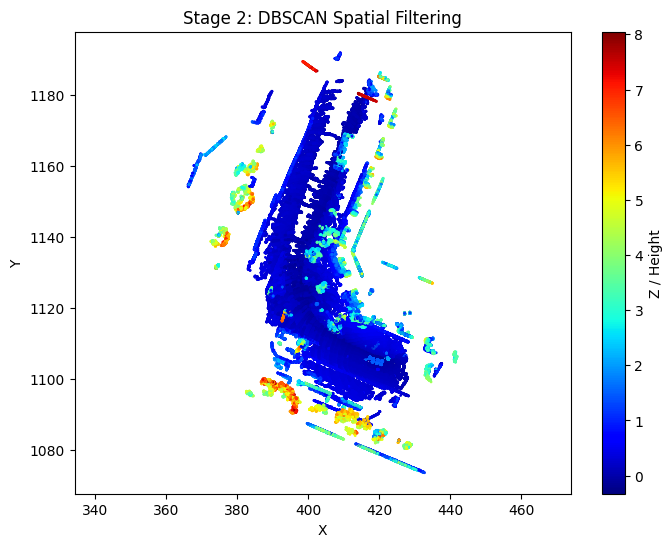

In [10]:
# 5.4 Stage 2: Spatial Filtering (DBSCAN)

pcd_stage1 = o3d.geometry.PointCloud()
pcd_stage1.points = o3d.utility.Vector3dVector(static_points_stage1)

# Apply DBSCAN clustering
labels = np.array(
    pcd_stage1.cluster_dbscan(
        eps=DBSCAN_EPS,
        min_points=DBSCAN_MIN_POINTS,
        print_progress=True
    )
)

# Keep clusters with enough points
cluster_sizes = np.bincount(labels[labels >= 0])
valid_clusters = set(np.where(cluster_sizes >= MIN_CLUSTER_SIZE)[0])
mask_stage2 = np.array([label in valid_clusters for label in labels])
static_points_stage2 = static_points_stage1[mask_stage2]

print(f"[Stage 2] DBSCAN spatial filtering: {static_points_stage2.shape[0]} points")

# Visualize Stage 2
visualize_stage(static_points_stage2, title="Stage 2: DBSCAN Spatial Filtering")

# Task-3: Point Cloud Colorization

**Goal:**
1. Enhance the static point cloud (Task 2 output) by assigning RGB colors
2. from camera images to improve visualization and interpretability


Starting realistic RGB colorization using nuScenes utilities...
Colored points: 598690/598690


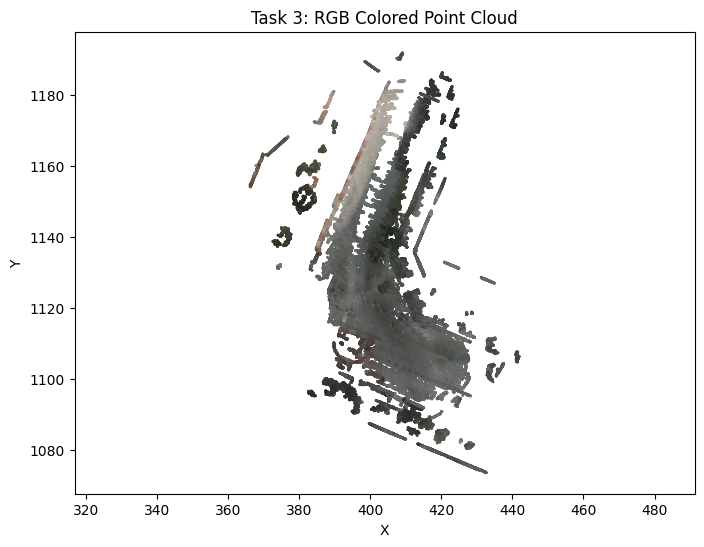

Saved realistic colored point cloud as static_colored_realistic.ply


In [11]:
# 6. Task 3: Realistic Dense RGB Colorization (Fixed Transform)
# Prepare for colorization
CAMERA_ORDER = ["CAM_FRONT", "CAM_FRONT_LEFT", "CAM_FRONT_RIGHT", "CAM_BACK"]

static_points = static_points_stage2
num_points = static_points.shape[0]

# Convert static points to LidarPointCloud
points_h = np.vstack((static_points.T, np.ones((1, num_points))))  # 4 x N
lidar_pc = LidarPointCloud(points_h)

# Initialize RGB accumulator and counter
color_accum = np.zeros((num_points, 3), dtype=np.float32)
color_count = np.zeros(num_points, dtype=np.int32)

print("Starting realistic RGB colorization using nuScenes utilities...")

sample_token = scene["first_sample_token"]

while sample_token:
    sample = nusc.get("sample", sample_token)
    
    for cam in CAMERA_ORDER:
        cam_token = sample["data"][cam]
        cam_sd = nusc.get("sample_data", cam_token)
        cam_cs = nusc.get("calibrated_sensor", cam_sd["calibrated_sensor_token"])
        ego_pose = nusc.get("ego_pose", cam_sd["ego_pose_token"])
        
        # Copy LiDAR point cloud
        lidar_cam = LidarPointCloud(lidar_pc.points.copy())
        
        # Transform LiDAR: world -> ego -> camera
        T_ego_world = pose_to_matrix(ego_pose["translation"], ego_pose["rotation"])
        T_cam_ego = pose_to_matrix(cam_cs["translation"], cam_cs["rotation"])
        lidar_cam.transform(np.linalg.inv(T_ego_world))
        lidar_cam.transform(np.linalg.inv(T_cam_ego))
        
        points_cam = lidar_cam.points[:3, :]  # 3 x N
        
        # Camera intrinsics
        K = np.array(cam_cs["camera_intrinsic"])
        img_path = os.path.join(nusc.dataroot, cam_sd["filename"])
        img = cv2.imread(img_path)[:, :, ::-1]  # BGR -> RGB
        h, w, _ = img.shape
        
        # Project points using nuScenes helper
        uv = view_points(points_cam, K, normalize=True)[:2, :]  # 2 x N
        u = uv[0, :]
        v = uv[1, :]
        
        # Only points in front of camera and inside image
        in_front = points_cam[2, :] > 0
        in_bounds = (u >= 0) & (u < w-1) & (v >= 0) & (v < h-1)
        valid = in_front & in_bounds
        idxs = np.where(valid)[0]
        
        if len(idxs) == 0:
            continue
        
        # Bilinear sampling
        coords = np.vstack([v[idxs], u[idxs]])  # rows=v, cols=u
        sampled_r = map_coordinates(img[:,:,0], coords, order=1, mode='nearest')
        sampled_g = map_coordinates(img[:,:,1], coords, order=1, mode='nearest')
        sampled_b = map_coordinates(img[:,:,2], coords, order=1, mode='nearest')
        sampled_colors = np.stack([sampled_r, sampled_g, sampled_b], axis=1)
        
        # Accumulate colors
        color_accum[idxs] += sampled_colors
        color_count[idxs] += 1
    
    sample_token = sample["next"]

# Average colors
colored_points = np.zeros((num_points,3), dtype=np.uint8)
mask = color_count > 0
colored_points[mask] = (color_accum[mask] / color_count[mask, None]).astype(np.uint8)

print(f"Colored points: {mask.sum()}/{num_points}")

# Visualization
pcd_colored = o3d.geometry.PointCloud()
pcd_colored.points = o3d.utility.Vector3dVector(static_points)
pcd_colored.colors = o3d.utility.Vector3dVector(colored_points.astype(float)/255.0)

# visualize_open3d function
visualize_open3d(static_points, colors=colored_points.astype(float)/255.0, window_name="Realistic Colored Point Cloud")

# save
o3d.io.write_point_cloud("static_colored_realistic.ply", pcd_colored)

def visualize_matplotlib_rgb(points, colors, title="Point Cloud"):
    """
    2D inline scatter of points with RGB colors (from 0-255 or 0-1 float)
    """
    import matplotlib.pyplot as plt
    colors = colors / 255.0 if colors.max() > 1 else colors
    plt.figure(figsize=(8,6))
    plt.scatter(points[:,0], points[:,1], c=colors, s=1)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.show()


visualize_matplotlib_rgb(static_points, colored_points, title="Task 3: RGB Colored Point Cloud")


print("Saved realistic colored point cloud as static_colored_realistic.ply")
